In [1]:
cd ..

/home/jovyan/Capstone/Github_my_version


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA, FastICA
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from lib.plr import PLR, connect_line, flatten

In [4]:
def up_down_trend(arr, epsilon):
    '''
    Classify point in a time series as either in an up trend or a down trend
    as determined by a PLR.
    
    Inputs
    - arr: numpy 1d-array of time-series values
    - epsilon: tolerance for PLR procedure
    
    Outputs
    - list of list of bools, where True indicates membership of an up trend
    '''
    pieces, lines, points = PLR(arr, epsilon)
    points.append(len(arr) - 1)
    diffs = np.diff(points)
    
    #I think this compensates for undercounting the first trend by one
    diffs[0] += 1 
    
    trend_labels = []
    
    for point, diff in zip(points[1:], diffs):
        up = [arr[point] - arr[point - 5] > 0]
        trend_labels.append(up * diff)
    
    return trend_labels


def trading_signal(arr, epsilon):
    '''
    Convert a time-series into a trading signal ranging from 0 to 1.
    For more information refer to "A dynamic threshold decision system ..."
    by Chang et al.
    
    Inputs
    - arr: numpy 1d-array of time-series values
    - epsilon: tolerance for PLR procedure
    
    Outputs
    - numpy 1d-array with the same length as arr
    '''
    labels = up_down_trend(arr, epsilon)
    
    final_signal_list = []
    for trend_list in labels:
        up = any(trend_list)
        length = len(trend_list)
        half_length, remainder = divmod(length, 2)
        
        if remainder:
            half_length += 1
            
        if up:
            first_half = 1 - np.arange(length) / length
        else:
            first_half = 0 + np.arange(length) / length
        
        if remainder:
            trend_signal = first_half
        else:
            trend_signal = first_half
        
        final_signal_list.append(trend_signal)
        
    return np.concatenate(final_signal_list)

In [6]:
apple_df = pd.read_csv("data/sandp500/individual_stocks_15yr_buy_or_sell/AAPL_data.csv")
# df = pd.concat([apple_df[61:], msft_df[61:]])
df = apple_df.tail(3526)
df = df.dropna(how = 'all', axis = 1)
df = df.drop("Acc/Dist_ROC_1" , axis = 1)
df = df.drop("Acc/Dist_ROC_5" , axis = 1)
df = df.drop("Acc/Dist_ROC_21" , axis = 1)
df = df.drop("Acc/Dist_ROC_63" , axis = 1)
df = df.drop("Acc/Dist_ROC_125" , axis = 1)
df = df.drop("Acc/Dist_ROC_250" , axis = 1)
df = df.dropna(how = 'any', axis = 1)
y = df['targets'].as_matrix()
drop_cols = ['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Name','Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Ex-Dividend', 'Split_Ratio',
             'Adj_Open', 'Adj_High', 'Adj_Low', 'Adj_Close', 'Adj_Volume']
df = df.drop(drop_cols, 1)
X = df.as_matrix()
X_sc = StandardScaler().fit_transform(X)

In [7]:
for signals in df['targets']:
    if signals >= 0.75:
        df.loc[df['targets'] == signals, 'targets_hold'] = 0
        df.loc[df['targets'] == signals, 'targets_buy'] = 1
        df.loc[df['targets'] == signals, 'targets_sell'] = 0
    if signals <= 0.25:
        df.loc[df['targets'] == signals, 'targets_hold'] = 0
        df.loc[df['targets'] == signals, 'targets_buy'] = 0
        df.loc[df['targets'] == signals, 'targets_sell'] = 1
    elif signals > 0.25 and signals < 0.75:
        df.loc[df['targets'] == signals, 'targets_hold'] = 1
        df.loc[df['targets'] == signals, 'targets_buy'] = 0
        df.loc[df['targets'] == signals, 'targets_sell'] = 0

# Technical Report

## Executive Summary

The goal of this capstone is to try to determine buy/sell points for a stock depending on numerous technical indicators and the closing price of the stock. The metrics being used for this report to determine accuracy is an R2 score, the MAE, and the MSE of the predicted values of the trading signal vs. the actual trading signal.

The findings so far have been somewhat limited. Kernel PCA and Support Vector Machines have been used to attempt to select relevant technical indicators in predicting the trading signal, however, there have not been any findings that would equate to solving the problem.

## Create Trading Signal

The trading signal was determined using trend lines. As the trend lines increase and approach a selling point, the trading signal approaches 0, or the signal to sell. On the other hand, as the trend lines decrease and approach a buying point, the trading signal increases to 1, the buying signal. Using this continuous signal, the goal is to find a relationship between the technical indicators and the trading signal so that in the future the trading signal could potentially be predicted from the technical indicators.

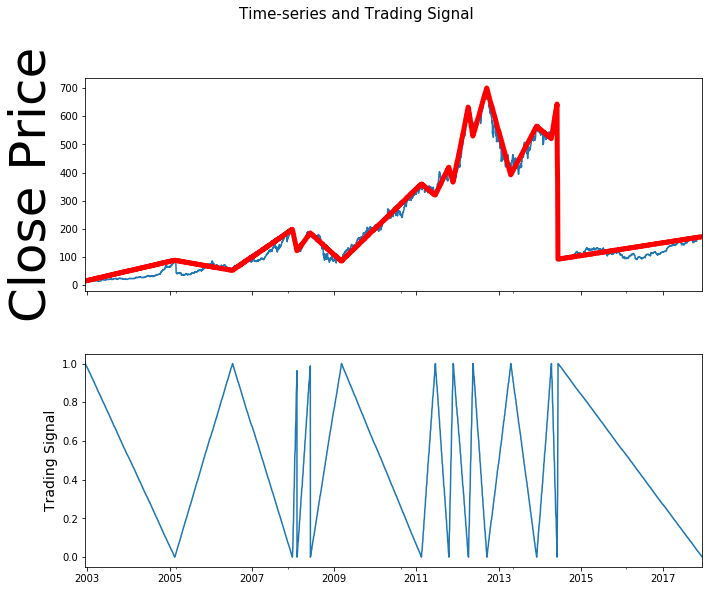

In [49]:
apple = pd.read_csv("data/sandp500/individual_stocks_15yr/AAPL_data.csv")
apple["Date"] = pd.to_datetime(apple["Date"])
apple = apple.set_index("Date")
close = apple["Close"].values

fig, (ax1, ax2) = plt.subplots(nrows = 2, sharex= True, figsize = (10, 8))
fig.suptitle("Time-series and Trading Signal", y = 1.02, size = 15)
xx = np.arange(len(close))
#ax1.plot(piece, c = "red")
apple["Close"].plot(ax = ax1 )
ax1.set_ylabel("Close Price", size = 50)

EPSILON = 50
piece, lines, points = PLR(close, EPSILON)
ax1.plot(apple.index, piece, c = "red", linewidth = 5, label = "PLR (threshold 20)")

ts= trading_signal(close, EPSILON)
ax2.plot(apple.index, ts)
ax2.set_ylabel("Trading Signal", size = 14)

plt.tight_layout()

## PCA and Model Selection

### Classification

In [11]:
buy_sell_df = df
buy_sell_df.sample(5)

,ADX_14_50,ATR_1,ATR_5,ATR_21,ATR_63,ATR_125,ATR_250,BollingerB_5,Bollinger%b_5,BollingerB_21,...,SO%k,Trix_1,Trix_5,Trix_21,Trix_63,TSI_25_13,targets,targets_hold,targets_buy,targets_sell
3413,0.306124,0.970,1.239917,1.546556,1.792208,2.008989,2.386382,0.015882,0.730543,0.078664,...,0.363636,0.004292,0.000593,-0.001059,-0.000875,-0.099807,0.410431,1.0,0.0,0.0
1643,0.304554,4.990,4.223137,3.774361,3.835616,4.205030,4.820197,0.070212,0.756265,0.091206,...,0.931864,0.026721,-0.001074,0.003868,0.002163,0.142083,0.845214,0.0,1.0,0.0
2351,0.479948,38.090,26.870772,17.608528,13.410006,11.437621,9.866071,0.119961,0.512241,0.093210,...,0.992124,0.050971,-0.003419,0.006170,0.003691,0.253082,0.206897,0.0,0.0,1.0
764,0.364449,1.830,1.432426,1.671991,1.747617,1.692947,1.653859,0.045086,0.737977,0.112859,...,0.227642,0.011997,0.001579,0.006766,0.003809,0.341693,0.612994,1.0,0.0,0.0
3574,0.634469,1.155,1.191132,1.374106,1.518163,1.630767,1.847432,0.006772,0.655453,0.154521,...,0.562771,0.001976,0.003419,0.003959,0.001312,0.750555,0.227891,0.0,0.0,1.0


Support Vector Classifier was fit using the GridSearchCV in order to see if it was possible to predict buy/sell points (0.75 or higher or 0.25 or lower). Using a train set of days 0-252, 378-630, and 756-1008 and a test set of 252-378, 630-756, and 1008-1134, the SVC model achieved the following:

Buy:
- KernelPCA(gamma = 65, kernel = 'sigmoid', n_components = 5) with polynomial SVC
- Train: 0.788
- Test: 0.778
- True Positive Rate: 1.0
- False Positive Rate: 0.228
- True Negative Rate: 0.772
- False Negative Rate: 0.0

Sell:
- KernelPCA(gamma = 0.1, kernel = 'sigmoid', n_components = 4) with polynomial SVC
- Train: 0.787
- Test: 0.902
- True Positive Rate: 0.0
- False Positive Rate: 0.0
- True Negative Rate: 1.0
- False Negative Rate: 1.0

Hold:
- KernelPCA(gamma = 0.1, kernel = 'rbf', n_components = 2) with sigmoid SVC
- Train: 0.618
- Test: 0.124
- True Positive Rate: 0.0
- False Positive Rate: 0.0
- True Negative Rate: 1.0
- False Negative Rate: 1.0

From the data above, it is easy to see that the Hold and Sell models were predicting to never hold or sell. The Buy model looks to have worked properly. Using the KernelPCA parameters above, let's explore the KernelPCA visualizations.

### Buy

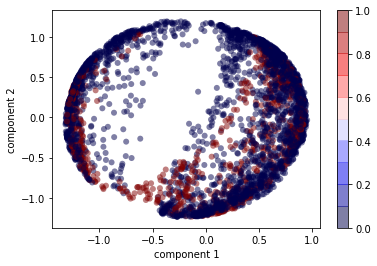

In [12]:
kpca = KernelPCA(random_state = 42,
                       gamma = 65,
                       kernel = 'sigmoid',
                       n_components = 5)
projected = kpca.fit_transform(X_sc)
plt.scatter(projected[:, 0], projected[:, 1],
            c=df['targets_buy'], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('seismic', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

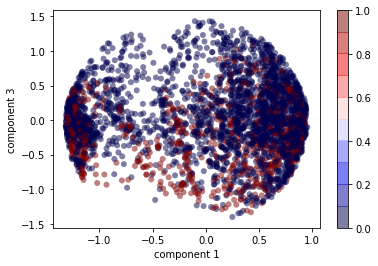

In [13]:
plt.scatter(projected[:, 0], projected[:, 2],
            c=df['targets_buy'], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('seismic', 10))
plt.xlabel('component 1')
plt.ylabel('component 3')
plt.colorbar();

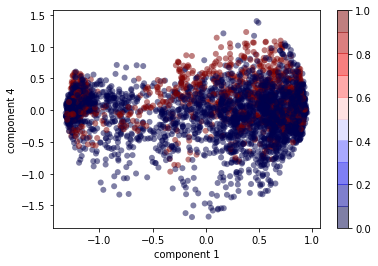

In [14]:
plt.scatter(projected[:, 0], projected[:, 3],
            c=df['targets_buy'], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('seismic', 10))
plt.xlabel('component 1')
plt.ylabel('component 4')
plt.colorbar();

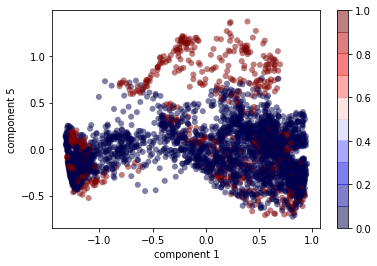

In [15]:
plt.scatter(projected[:, 0], projected[:, 4],
            c=df['targets_buy'], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('seismic', 10))
plt.xlabel('component 1')
plt.ylabel('component 5')
plt.colorbar();

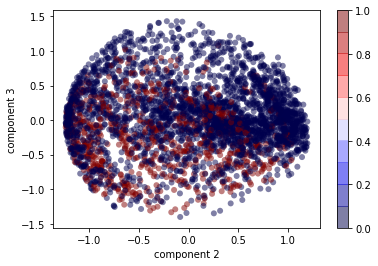

In [16]:
plt.scatter(projected[:, 1], projected[:, 2],
            c=df['targets_buy'], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('seismic', 10))
plt.xlabel('component 2')
plt.ylabel('component 3')
plt.colorbar();

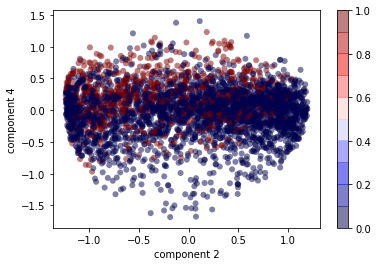

In [17]:
plt.scatter(projected[:, 1], projected[:, 3],
            c=df['targets_buy'], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('seismic', 10))
plt.xlabel('component 2')
plt.ylabel('component 4')
plt.colorbar();

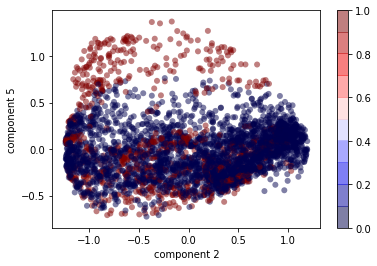

In [18]:
plt.scatter(projected[:, 1], projected[:, 4],
            c=df['targets_buy'], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('seismic', 10))
plt.xlabel('component 2')
plt.ylabel('component 5')
plt.colorbar();

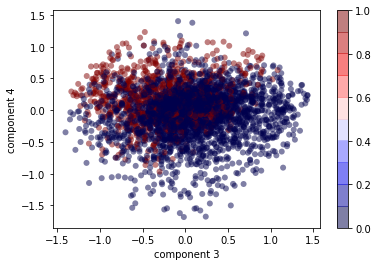

In [19]:
plt.scatter(projected[:, 2], projected[:, 3],
            c=df['targets_buy'], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('seismic', 10))
plt.xlabel('component 3')
plt.ylabel('component 4')
plt.colorbar();

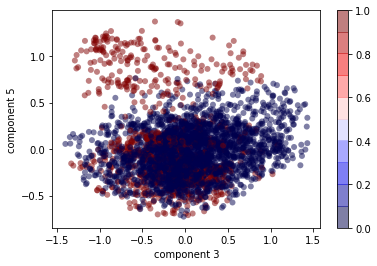

In [20]:
plt.scatter(projected[:, 2], projected[:, 4],
            c=df['targets_buy'], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('seismic', 10))
plt.xlabel('component 3')
plt.ylabel('component 5')
plt.colorbar();

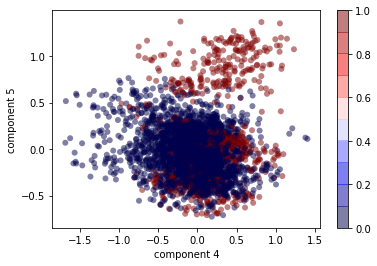

In [21]:
plt.scatter(projected[:, 3], projected[:, 4],
            c=df['targets_buy'], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('seismic', 10))
plt.xlabel('component 4')
plt.ylabel('component 5')
plt.colorbar();

### Sell

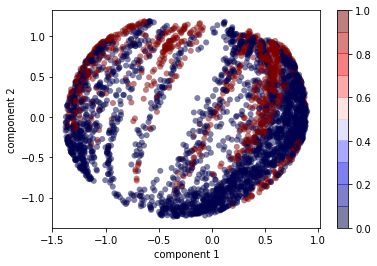

In [22]:
kpca = KernelPCA(random_state = 42,
                       gamma = 0.1,
                       kernel = 'sigmoid',
                       n_components = 4)
projected = kpca.fit_transform(X_sc)
plt.scatter(projected[:, 0], projected[:, 1],
            c=df['targets_sell'], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('seismic', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

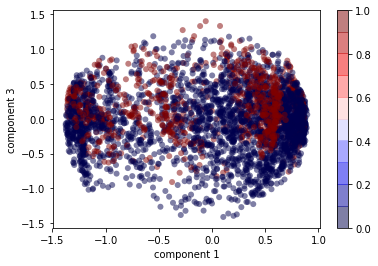

In [23]:
plt.scatter(projected[:, 0], projected[:, 2],
            c=df['targets_sell'], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('seismic', 10))
plt.xlabel('component 1')
plt.ylabel('component 3')
plt.colorbar();

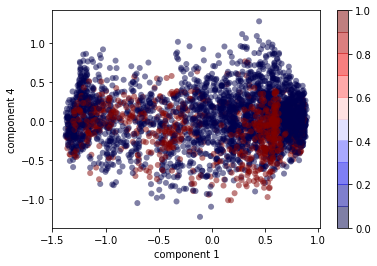

In [24]:
plt.scatter(projected[:, 0], projected[:, 3],
            c=df['targets_sell'], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('seismic', 10))
plt.xlabel('component 1')
plt.ylabel('component 4')
plt.colorbar();

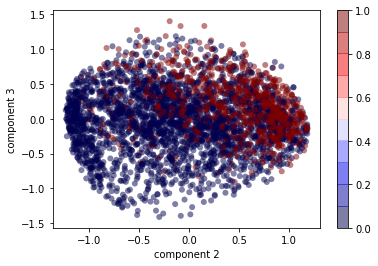

In [25]:
plt.scatter(projected[:, 1], projected[:, 2],
            c=df['targets_sell'], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('seismic', 10))
plt.xlabel('component 2')
plt.ylabel('component 3')
plt.colorbar();

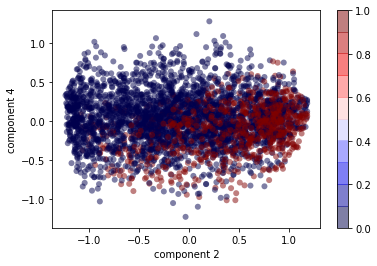

In [26]:
plt.scatter(projected[:, 1], projected[:, 3],
            c=df['targets_sell'], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('seismic', 10))
plt.xlabel('component 2')
plt.ylabel('component 4')
plt.colorbar();

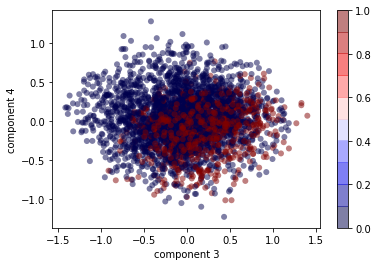

In [27]:
plt.scatter(projected[:, 2], projected[:, 3],
            c=df['targets_sell'], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('seismic', 10))
plt.xlabel('component 3')
plt.ylabel('component 4')
plt.colorbar();

### Hold

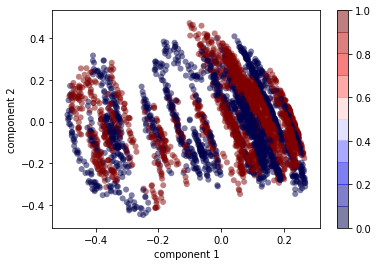

In [28]:
kpca = KernelPCA(random_state = 42,
                       gamma = 0.001,
                       kernel = 'rbf',
                       n_components = 2)
projected = kpca.fit_transform(X_sc)
plt.scatter(projected[:, 0], projected[:, 1],
            c=df['targets_hold'], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('seismic', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

From the above visualizations, it is relatively easy to see why the Hold model is struggling to perform. However, the sell kernel looks to be separating the sell and not sell points better than what the model score is returning.

### Regression

#### KernelPCA

When the continuous trading signal is used for analysis and a Support Vector Regressor is used instead of a Support Vector Classifier, the following output was achieved:

- KernelPCA(eigen_solver = 'arpack', gamma = 0.25, kernel = 'rbf', n_components = 5) with rbf SVR
- Train Score (R^2): 0.148
- Test Score (R^2): -0.961

Clearly a test score of -1 is not a good score as if we simply guessed every time, we could most likely beat this score.

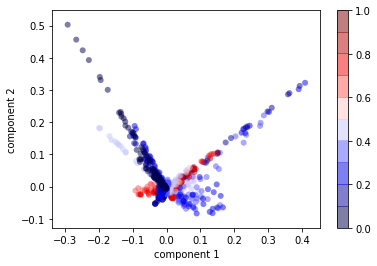

In [29]:
kpca = KernelPCA(random_state = 42,
                       gamma = 0.25,
                       kernel = 'rbf',
                       n_components = 5,
                       eigen_solver = 'arpack')
projected = kpca.fit_transform(X_sc)
plt.scatter(projected[:, 0], projected[:, 1],
            c=y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('seismic', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

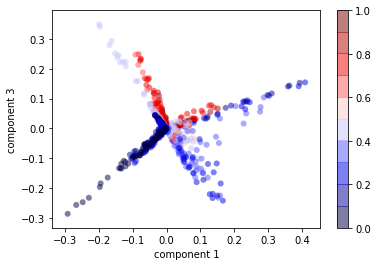

In [30]:
plt.scatter(projected[:, 0], projected[:, 2],
            c=y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('seismic', 10))
plt.xlabel('component 1')
plt.ylabel('component 3')
plt.colorbar();

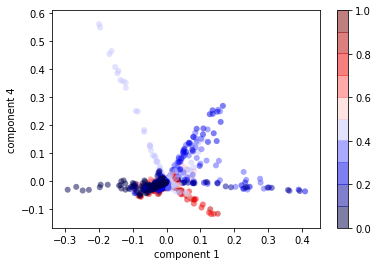

In [31]:
plt.scatter(projected[:, 0], projected[:, 3],
            c=y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('seismic', 10))
plt.xlabel('component 1')
plt.ylabel('component 4')
plt.colorbar();

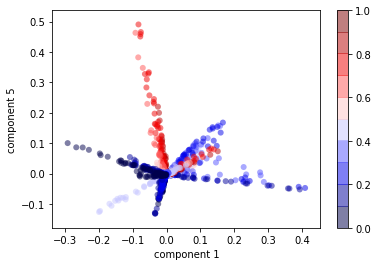

In [32]:
plt.scatter(projected[:, 0], projected[:, 4],
            c=y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('seismic', 10))
plt.xlabel('component 1')
plt.ylabel('component 5')
plt.colorbar();

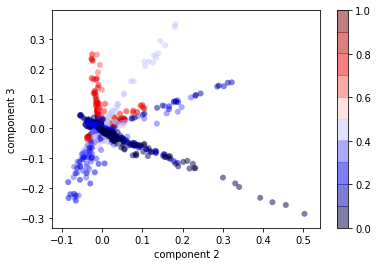

In [33]:
plt.scatter(projected[:, 1], projected[:, 2],
            c=y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('seismic', 10))
plt.xlabel('component 2')
plt.ylabel('component 3')
plt.colorbar();

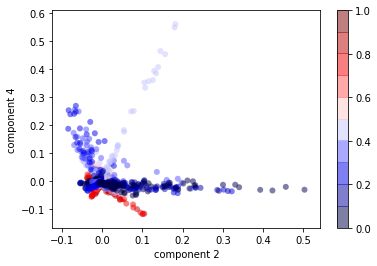

In [34]:
plt.scatter(projected[:, 1], projected[:, 3],
            c=y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('seismic', 10))
plt.xlabel('component 2')
plt.ylabel('component 4')
plt.colorbar();

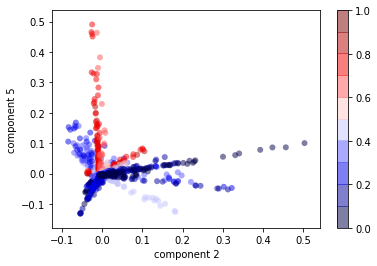

In [35]:
plt.scatter(projected[:, 1], projected[:, 4],
            c=y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('seismic', 10))
plt.xlabel('component 2')
plt.ylabel('component 5')
plt.colorbar();

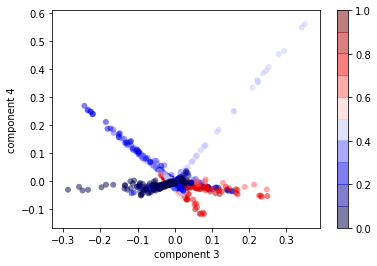

In [36]:
plt.scatter(projected[:, 2], projected[:, 3],
            c=y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('seismic', 10))
plt.xlabel('component 3')
plt.ylabel('component 4')
plt.colorbar();

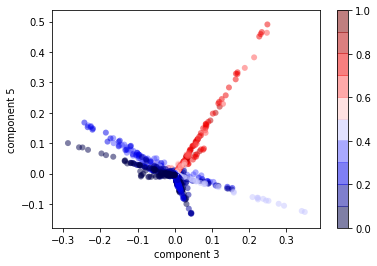

In [37]:
plt.scatter(projected[:, 2], projected[:, 4],
            c=y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('seismic', 10))
plt.xlabel('component 3')
plt.ylabel('component 5')
plt.colorbar();

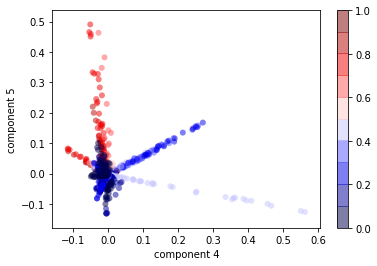

In [38]:
plt.scatter(projected[:, 3], projected[:, 4],
            c=y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('seismic', 10))
plt.xlabel('component 4')
plt.ylabel('component 5')
plt.colorbar();

#### FastICA

When the continuous trading signal is used for analysis and a FastICA is used instead of a KernelPCA, the following output was achieved:

- FastICA(algorithm = 'parallel', fun = 'cube', n_components = 10) with sigmoid SVR
- Train Score (R^2): 0.100
- Test Score (R^2): -0.710

Once again, this score is not a good R^2 score. Let's look at the visualization of the FastICA and a few of the ten components.

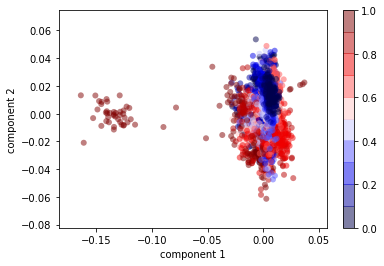

In [39]:
ica = FastICA(algorithm = 'parallel',
              fun = 'cube',
              n_components = 10)
projected = ica.fit_transform(X_sc)
plt.scatter(projected[:, 0], projected[:, 1],
            c=y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('seismic', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

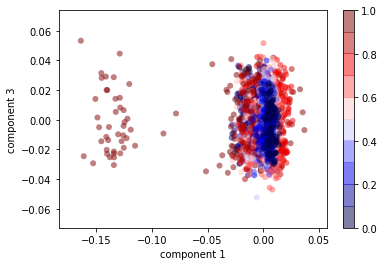

In [40]:
plt.scatter(projected[:, 0], projected[:, 2],
            c=y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('seismic', 10))
plt.xlabel('component 1')
plt.ylabel('component 3')
plt.colorbar();

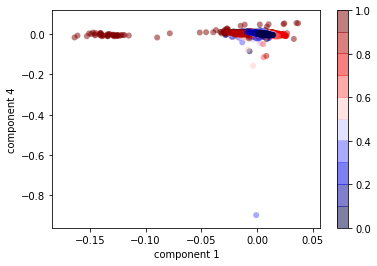

In [41]:
plt.scatter(projected[:, 0], projected[:, 3],
            c=y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('seismic', 10))
plt.xlabel('component 1')
plt.ylabel('component 4')
plt.colorbar();

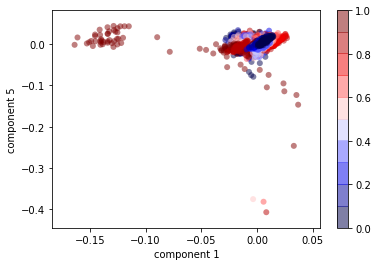

In [42]:
plt.scatter(projected[:, 0], projected[:, 4],
            c=y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('seismic', 10))
plt.xlabel('component 1')
plt.ylabel('component 5')
plt.colorbar();

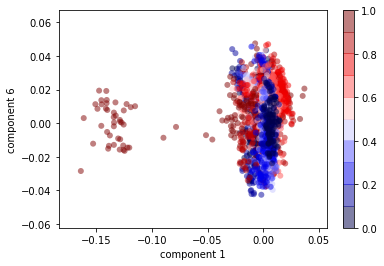

In [43]:
plt.scatter(projected[:, 0], projected[:, 5],
            c=y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('seismic', 10))
plt.xlabel('component 1')
plt.ylabel('component 6')
plt.colorbar();

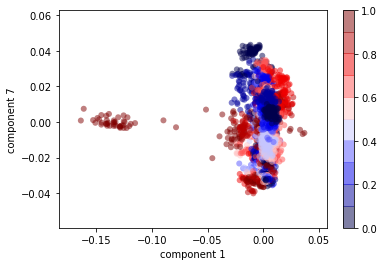

In [44]:
plt.scatter(projected[:, 0], projected[:, 6],
            c=y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('seismic', 10))
plt.xlabel('component 1')
plt.ylabel('component 7')
plt.colorbar();

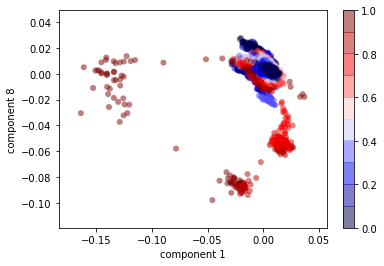

In [45]:
plt.scatter(projected[:, 0], projected[:, 7],
            c=y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('seismic', 10))
plt.xlabel('component 1')
plt.ylabel('component 8')
plt.colorbar();

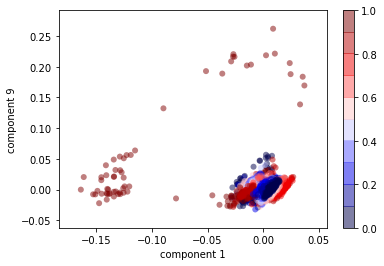

In [46]:
plt.scatter(projected[:, 0], projected[:, 8],
            c=y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('seismic', 10))
plt.xlabel('component 1')
plt.ylabel('component 9')
plt.colorbar();

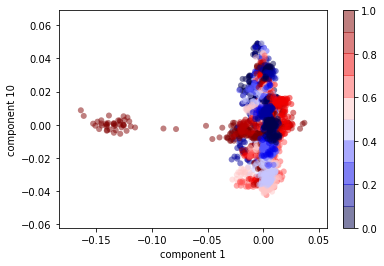

In [47]:
plt.scatter(projected[:, 0], projected[:, 9],
            c=y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('seismic', 10))
plt.xlabel('component 1')
plt.ylabel('component 10')
plt.colorbar();

## Future Work

Continue to work with PCA, KernelPCA, and ICA to separate the buy and sell marks more drastically. Since only SVC and SVR have been tried, it may be a good idea to try a different model such as RandomForest or KNeighborsRegressor. AAPL is the only stock that has been used for analysis, so need to continue to validate findings using other stocks. Other stocks may also help to better test scores as the more data the models see, the test score may continue to rise.

Another idea was to go back and explore all of the technical indicators and their distributions to determine whether or not they are normalized. I may have to do some deskewing in order to get my scores to improve.